## Prediciting the 2012 US elections
### Main aim is to learn modelling the prediciton forecasts to put this into practice for the 2016 elections
We are going to focus on the 2012 Presidential election. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states. We will explore how hard it is to recreate similarly successful models. The goals of this assignment are:

1. To practice data manipulation with Pandas
1. To develop intuition about the interplay of **precision**, **accuracy**, and **bias** when making predictions
1. To better understand how election forecasts are constructed

The data for our analysis will come from demographic and polling data. We will simulate building our model on October 2, 2012 -- approximately one month before the election. 

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

C:\Users\Samsung\Anaconda2\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

## Today: the day we make the prediction

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

## Background: The Electoral College

US Presidential elections revolve around the <a href="http://en.wikipedia.org/wiki/Electoral_College_(United_States)"> Electoral College </a>. In this system, each state receives a number of Electoral College votes depending on it's population -- there are 538 votes in total. In most states, all of the electoral college votes are awarded to the presidential candidate who recieves the most votes in that state. A candidate needs 269 votes to be elected President. 

Thus, to calculate the total number of votes a candidate gets in the election, we add the electoral college votes in the states that he or she wins. (This is not entirely true, with Nebraska and Maine splitting their electoral college votes, but, for the purposes of this homework, we shall assume that the winner of the most votes in Maine and Nebraska gets ALL the electoral college votes there.) 

Here is the electoral vote breakdown by state:
*As a matter of convention, we will index all our dataframes by the state name*

In [5]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


To illustrate the use of `make_map` we plot the Electoral College

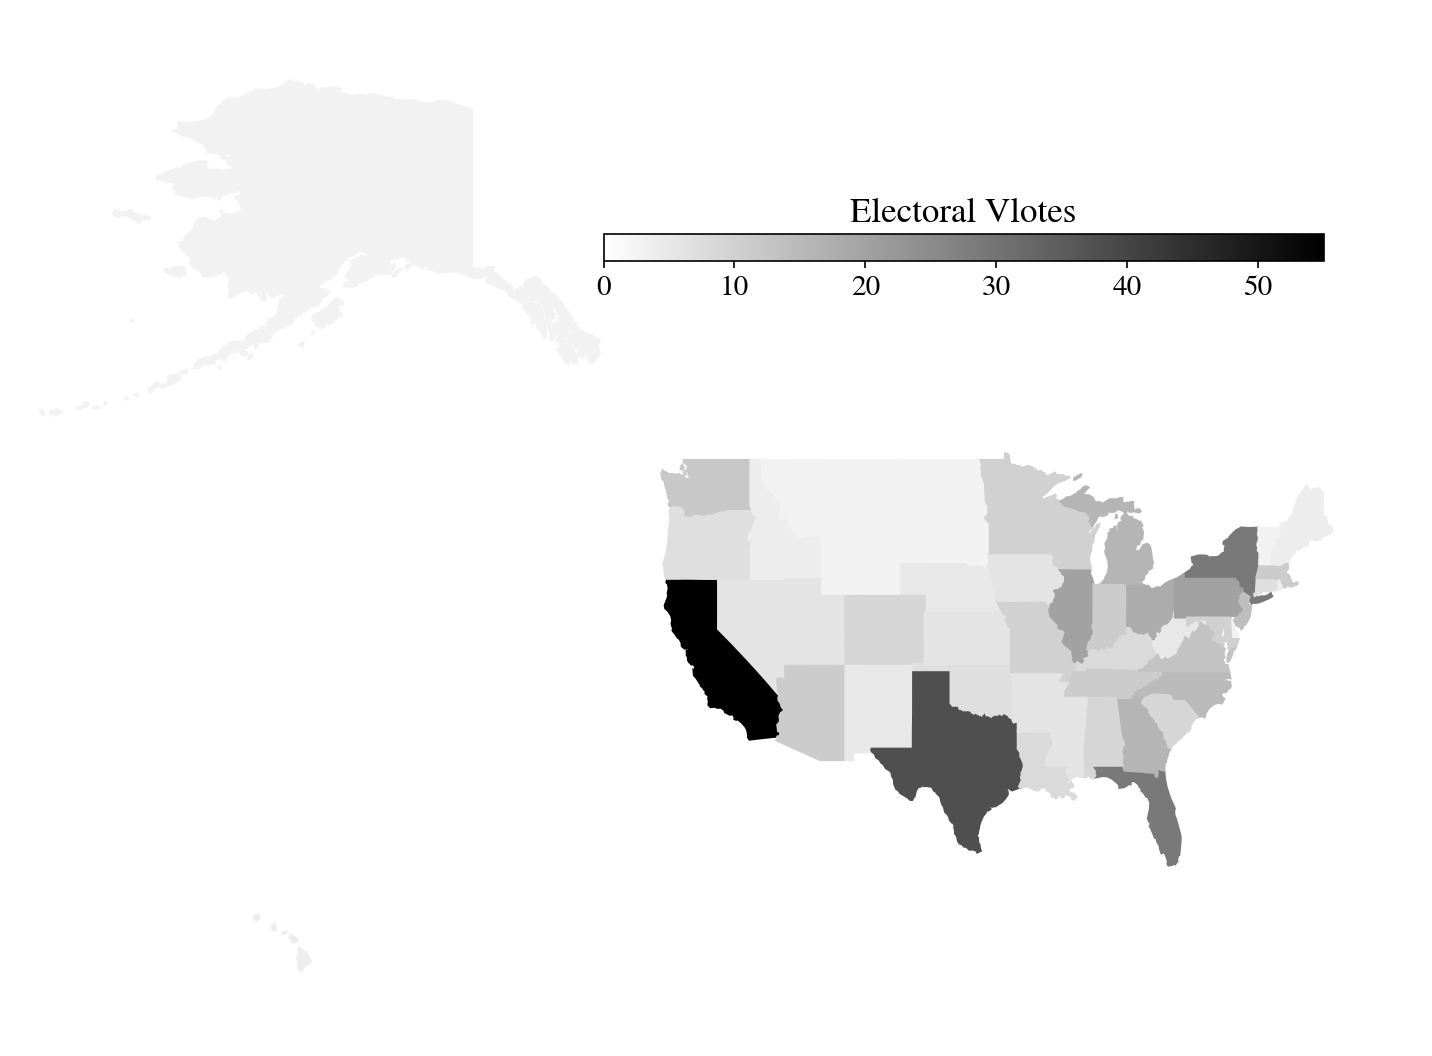

In [6]:
make_map(electoral_votes.Votes, "Electoral Vlotes")

## The PredictWise Baseline

We will start by examining a successful forecast that [PredictWise](http://www.predictwise.com/results/2012/president) made on October 2, 2012. This will give us a point of comparison for our own forecast models.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:

### Simulating the election

In [7]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


*Each row is the probability predicted by Predictwise that Romney or Obama would win a state. The votes column lists the number of electoral college votes in that state. Let's plot a map of the probability that Obama wins each state, according to this prediction*.

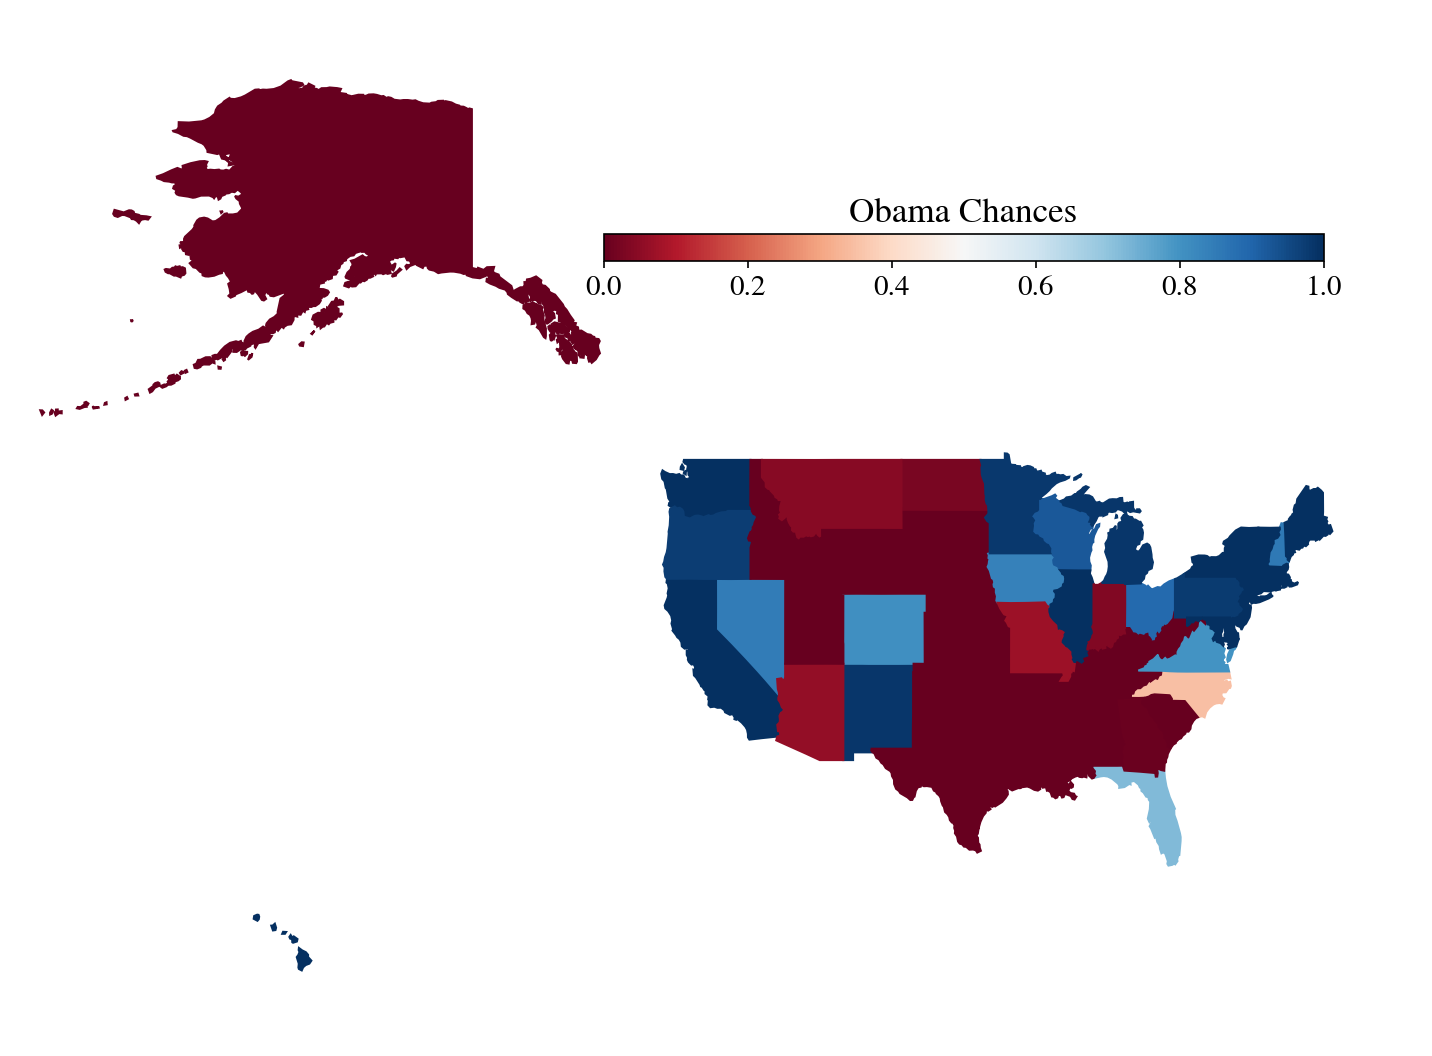

In [8]:
make_map(predictwise.Obama,"Obama Chances")

Later on we will explore some approaches to estimating probabilities like these and quatifying our uncertainty about them. But for the time being, we will focus on how to make a prediction assuming these probabilities are known.

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty. From these simulations, we will be able to make a prediction about the expected outcome of the election, and make a statement about how sure we are about it.


#### Simulating the model

In [9]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""

def simulate_election(model,n_sim):
    sims = np.random.uniform(size = (51,n_sim))
    sim_result = (sims < model.Obama.reshape(-1,1)) * model.Votes.reshape(-1,1)
    return sim_result.sum(axis=0)

**What assigning the vote to Obama when the random variable **Drawn** from the Uniform distribution is less than the Predictwise probability of Obama winning (which is a Bernoulli Parameter) does for us is this: if we have a large number of simulations and $p_{Obama}=0.7$ , then 70\% of the time, the random numbes drawn will be below 0.7. And then, assigning those as Obama wins will hew to the frequentist notion of probability of the Obama win. But remember, of course, that in 30% of the simulations, Obama wont win, and this will induce fluctuations and a distribution on the total number of electoral college votes that Obama gets. And this is what we see in the histogram below.** 

The following cells takes the necessary DataFrame for the Predictwise data, and runs 10000 simulations. We use the results to compute the probability, according to this predictive model, that Obama wins the election (i.e., the probability that he receives 269 or more electoral college votes)

In [10]:
result = simulate_election(predictwise, 10000)
result.std()

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


18.579866802267446

In [11]:
#compute the probability of an Obama win, given this simulation

prob = (result>269).mean()
prob

0.99490000000000001

#### Visualising the simulation

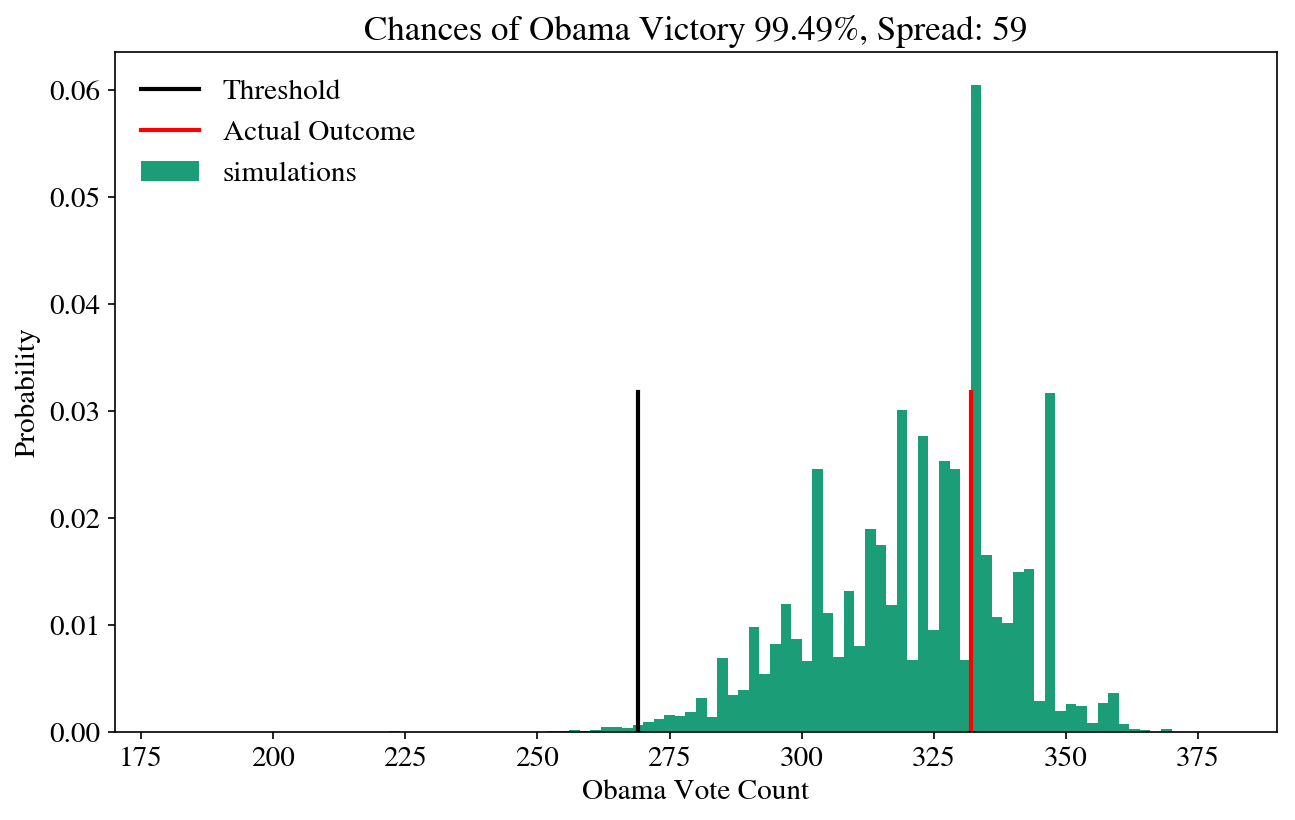

In [12]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes Obama wins in each simulation.
    
Returns
-------
Nothing 
"""

#import seaborn as sns
def plot_simulation(sim):
    f,ax = plt.subplots()
    ax.hist(sim ,bins =100, range = (180,380),normed=True,label = 'simulations')
    plt.axvline(x=269,color='black',ymax = 0.5,label='Threshold')
    plt.axvline(x=332,color='r',ymax = 0.5,label='Actual Outcome')
    p5 = np.percentile(sim,5.)
    p95 = np.percentile(sim,95.)
    spread = p95 - p5
    plt.ylabel('Probability')
    plt.xlabel('Obama Vote Count')
    plt.title('Chances of Obama Victory %0.2f%%, Spread: %d'%((sim>269).mean()*100,spread))
    plt.legend(frameon=False,loc='best')
    #sns.despine()
plot_simulation(result)
    

In [13]:
print 'Mean vote count for obama from our simulated model :', result.mean()

Mean vote count for obama from our simulated model : 320.7969


#### Evaluating and Validating our Forecast

The point of creating a probabilistic predictive model is to simultaneously make a forecast and give an estimate of how certain we are about it. 

However, in order to trust our prediction or our reported level of uncertainty, the model needs to be *correct*. We say a model is *correct* if it honestly accounts for all of the mechanisms of variation in the system we're forecasting.
*What does the above plot reveal about the **accuracy** and **precision** of the PredictWise model?*

To evaluate the **accuracy** of our prediction, we can check to see whether the expectation of our predictive distribution seems to match the expectation of the true outcome. In this case, much of the predictive distribution's mass lies on or around the real outcome (that is, the histogram is approximately centered on the actual outcome of Obama=332 votes). So, based on the outcome we observed, the model seems accurate. To make a more rigorous statement about accuracy, we would want to have more replications (that is, more elections) to see whether the expectation of the predictive distribution consistently matches the true outcomes.
To evaluate the **precision** of our prediction, we look at the spread of the histogram. Because we are assuming the model is correct, we can interpret the spread of the histogram as a measure of the variability among the election outcomes that are consistent with the information we have. If our current information does not constrain the likely election outcomes very much, then the difference between our prediction and the true outcome can vary widely. The spread of the histogram is 60 votes, which is relatively large. Whether the prediction is precise enough is a question of what you want to do with your prediction. For example, if you want to be able to call the winner of a close election (say the candidates are separated by less than 30 votes), this prediction would not be precise enough to identify a winner with 95% confidence. To handle this, we might wish to incorporate more information into the model to reduce the spread of likely election outcomes.

*Unfortunately all models are wrong but some are useful*

### Gallup Party Affiliation Poll

Now we will try to **estimate** our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with.

In [14]:
gallup_2012=pd.read_csv("data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


Each row lists a state, the percent of surveyed individuals who identify as Democrat/Republican, the percent whose identification is unknown or who haven't made an affiliation yet, the margin between Democrats and Republicans (`Dem_Adv`: the percentage identifying as Democrats minus the percentage identifying as Republicans), and the number `N` of people surveyed.


The most obvious source of error in the Gallup data is the finite sample size -- Gallup did not poll *everybody* in America, and thus the party affilitions are subject to sampling errors. How much uncertainty does this introduce? Lets estimate the sampling error using what we learnt in the last section

If $V_m$ denotes the variance of a sample, 

$$ N\,V_m = \sum_{i=1}^{N} (x_{mi} - \bar{x_m})^2 = \sum_{i=1}^{N}(x_{mi} - \mu)^2 - N\,(\bar{x_m} - \mu)^2. $$

Then
$$E_{\{R\}}(N\,V_m) = E_{\{R\}}(\sum_{i=1}^{N}(x_{mi} - \mu)^2) - E_{\{R\}}(N\,(\bar{x_m} - \mu)^2)$$
In the asymptotic limit of a very large number of replicates, we can then write
$$E(N\,V) = N\,\sigma^2 - \sigma^2, $$
and thus we have
$$E(V) = \frac{N-1}{N} \,\sigma^2$$.

In other words, the expected value of the sample variance is LESS than the actual variance. This should not be surprising: consider for example a sample of size 1 from the population. There is zero variance! More genrally, whenever you sample a population, you tend to pick the more likely members of the population, and so the variance in the sample is less than the variance in the population.

An interesting application of this idea, as Shalizi points out in http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/, is that the loss of variability due to sampling of genes is indeed the origin of genetic drift. More prosaically, the fact that the above graph of expected sample variance against sample size asymptotes to 0.25 is as $\frac{N-1}{N}$ if very close to 1 at large N. 

Or put another way, you ought to correct your sample variances by a factor of $\frac{n}{n-1}$ to estimate the population variance, which itself works as the sampling distribution of the sample variance is rather tight, as seen below.

In [15]:
gallup_2012["SE_percentage"]=100.0*np.sqrt((gallup_2012.Democrat/100.)*((100. - gallup_2012.Democrat)/100.)/(gallup_2012.N -1))
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown,SE_percentage
State,,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4,0.849059
Alaska,35.9,44.3,-8.4,402,19.8,2.395543
Arizona,39.8,47.3,-7.5,4325,12.9,0.744384
Arkansas,41.5,40.8,0.7,2071,17.7,1.082971
California,48.3,34.6,13.7,16197,17.1,0.392658


On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the sampling error for the states is between 3 and 6%, with it being 3% for most states. This is more than what we find, so lets go with what Gallup says.

We now use Gallup's estimate of 3% to build a Gallup model with some uncertainty. We will, using the CLT, assume that the sampling distribution of the Obama win percentage is a gaussian with mean the democrat percentage and standard error the sampling error of 3\%. 

We'll build the model in the function `uncertain_gallup_model`, and return a forecast where the probability of an Obama victory is given by the probability that a sample from the `Dem_Adv` Gaussian is positive.

To do this we simply need to find the area under the curve of a Gaussian that is on the positive side of the x-axis.
The probability that a sample from a Gaussian with mean $\mu$ and standard deviation $\sigma$ exceeds a threhold $z$ can be found using the the Cumulative Distribution Function of a Gaussian:

$$
CDF(z) = \frac1{2}\left(1 + {\mathrm erf}\left(\frac{z - \mu}{\sqrt{2 \sigma^2}}\right)\right) 
$$

In [16]:
from scipy.stats import norm
def uncertain_gallup_model(df):
    from scipy.stats import norm
    x = norm.sf(0,df.Dem_Adv,3)
    return pd.DataFrame({'Obama':x},index=df.index)

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


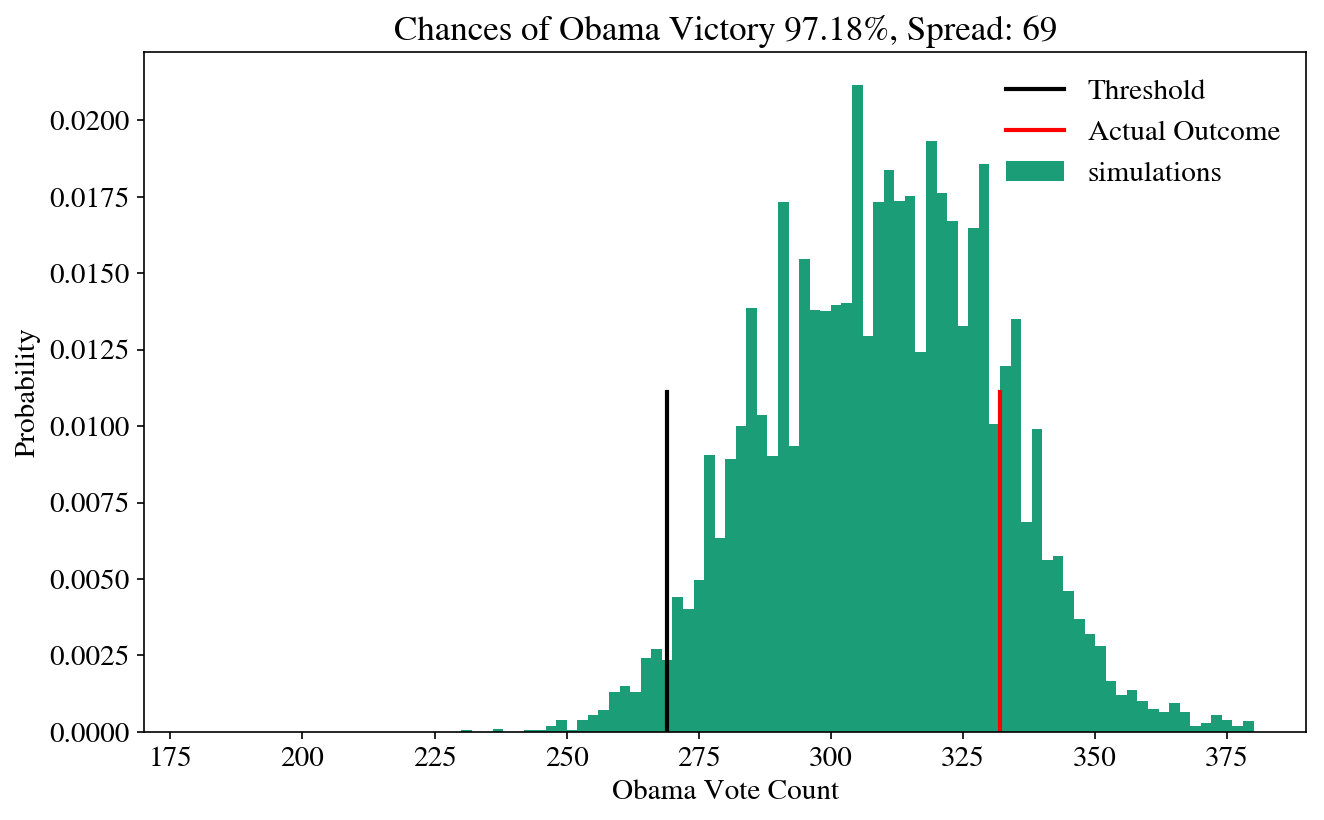

In [17]:
model_gallup = uncertain_gallup_model(gallup_2012)
model_gallup = model_gallup.join(electoral_votes)
simulated_gallup = simulate_election(model_gallup,10000)
plot_simulation(simulated_gallup)

The predictive distribution is consistent with the real data -- the real outcome seems like a typical outcome according to the model. The accuracy is not very good as the center of the distribution falls fairly far from the observed outcome, but the precision is only marginally worse than in the predictwise case.

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


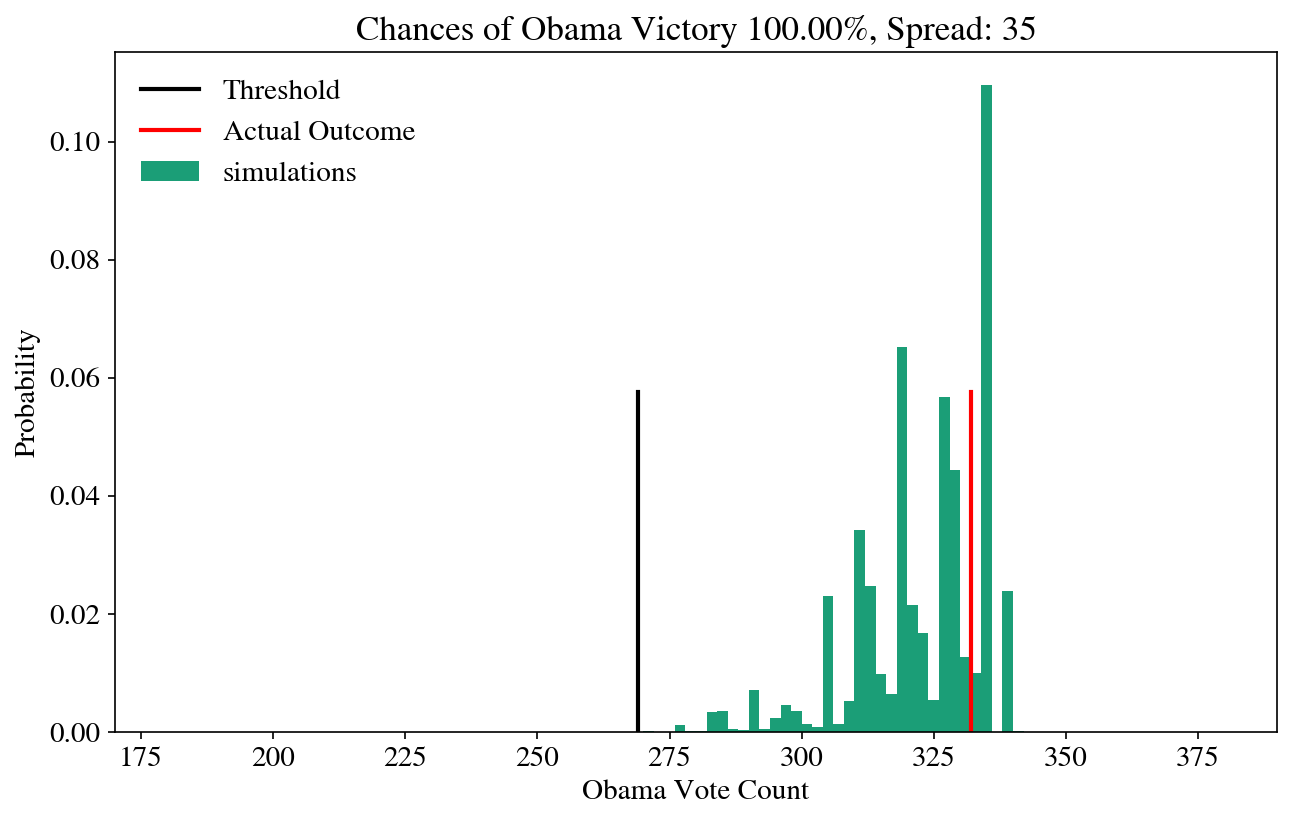

In [18]:
def uncertain_gallup_model(df):
    from scipy.stats import norm
    x = norm.sf(0,df.Dem_Adv,df.SE_percentage)
    return pd.DataFrame({'Obama':x},index=df.index)
model_gallup = uncertain_gallup_model(gallup_2012)
model_gallup = model_gallup.join(electoral_votes)
simulated_gallup = simulate_election(model_gallup,10000)
plot_simulation(simulated_gallup)

### Biases
While accounting for uncertainty is one important part of making predictions, we also want to avoid systematic errors. We call systematic over- or under-estimation of an unknown quantity bias. In the case of this forecast, our predictions would be biased if the estimates from this poll systematically over- or under-estimate vote proportions on election day. There are several reasons this might happen:


**1.**Gallup is wrong. The poll may systematically over- or under-estimate party affiliation. This could happen if the people who answer Gallup phone interviews might not be a representative sample of people who actually vote, Gallup's methodology is flawed, or if people lie during a Gallup poll.

**2.**Our assumption about party affiliation is wrong. Party affiliation may systematically over- or under-estimate vote proportions. This could happen if people identify with one party, but strongly prefer the candidate from the other party, or if undecided voters do not end up splitting evenly between Democrats and Republicans on election day.


**3.**Our assumption about equilibrium is wrong. This poll was released in August, with more than two months left for the elections. If there is a trend in the way people change their affiliations during this time period (for example, because one candidate is much worse at televised debates), an estimate in August could systematically miss the true value in November.
One way to account for bias is to calibrate our model by estimating the bias and adjusting for it. Before we do this, let's explore how sensitive our prediction is to bias.

In [19]:
"""
Function
--------
biased_gallup_poll

Subtracts a fixed amount from Dem_Adv, beofore computing the uncertain_gallup_model.
This simulates correcting a hypothetical bias towards Democrats
in the original Gallup data.

Inputs
-------
gallup : DataFrame
    The Gallup party affiliation data frame above
bias : float
    The amount by which to shift each prediction
    
Examples
--------
>>> model = biased_gallup(gallup, 1.)
>>> model.ix['Flordia']
>>> .460172
"""
def biased_gallup(gallup, bias):
    g2 = gallup.copy()
    g2.Dem_Adv -= bias
    return uncertain_gallup_model(g2)

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


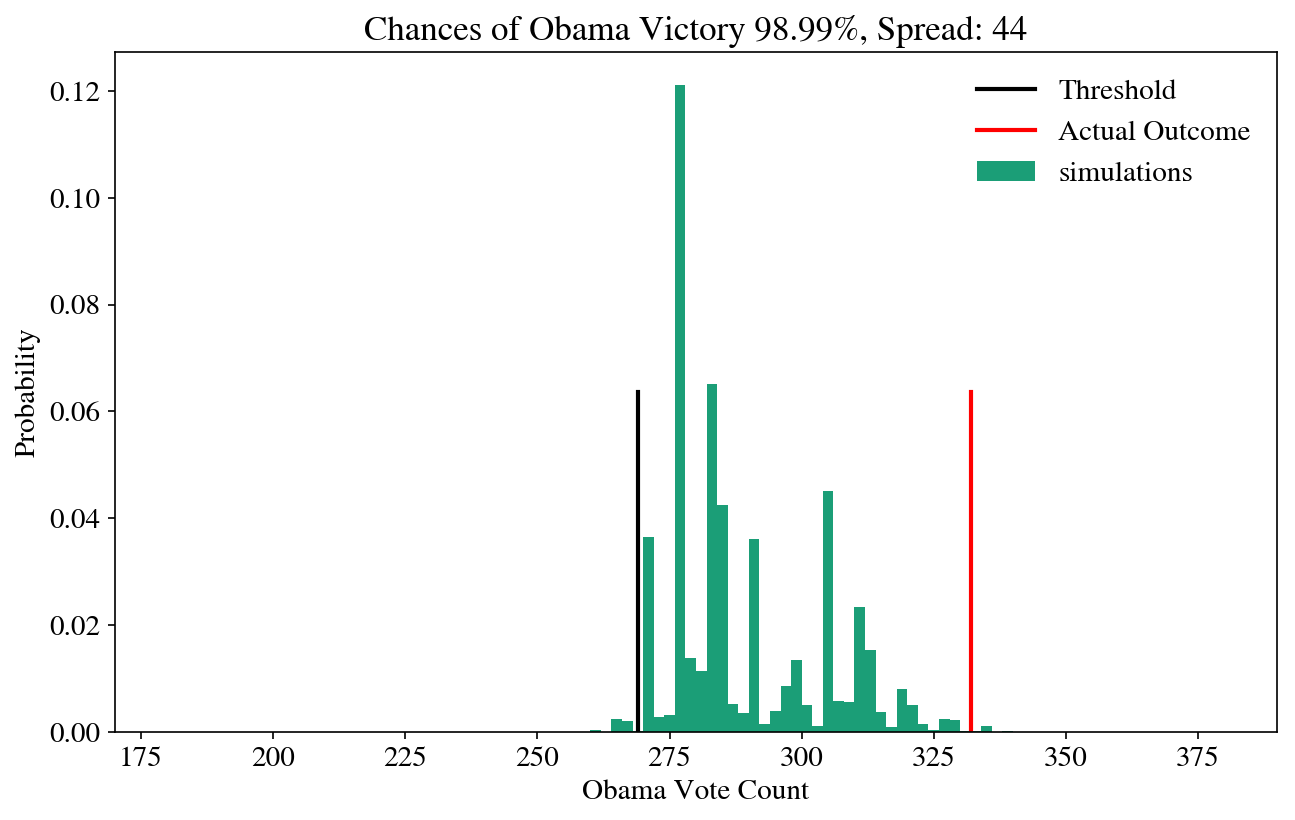

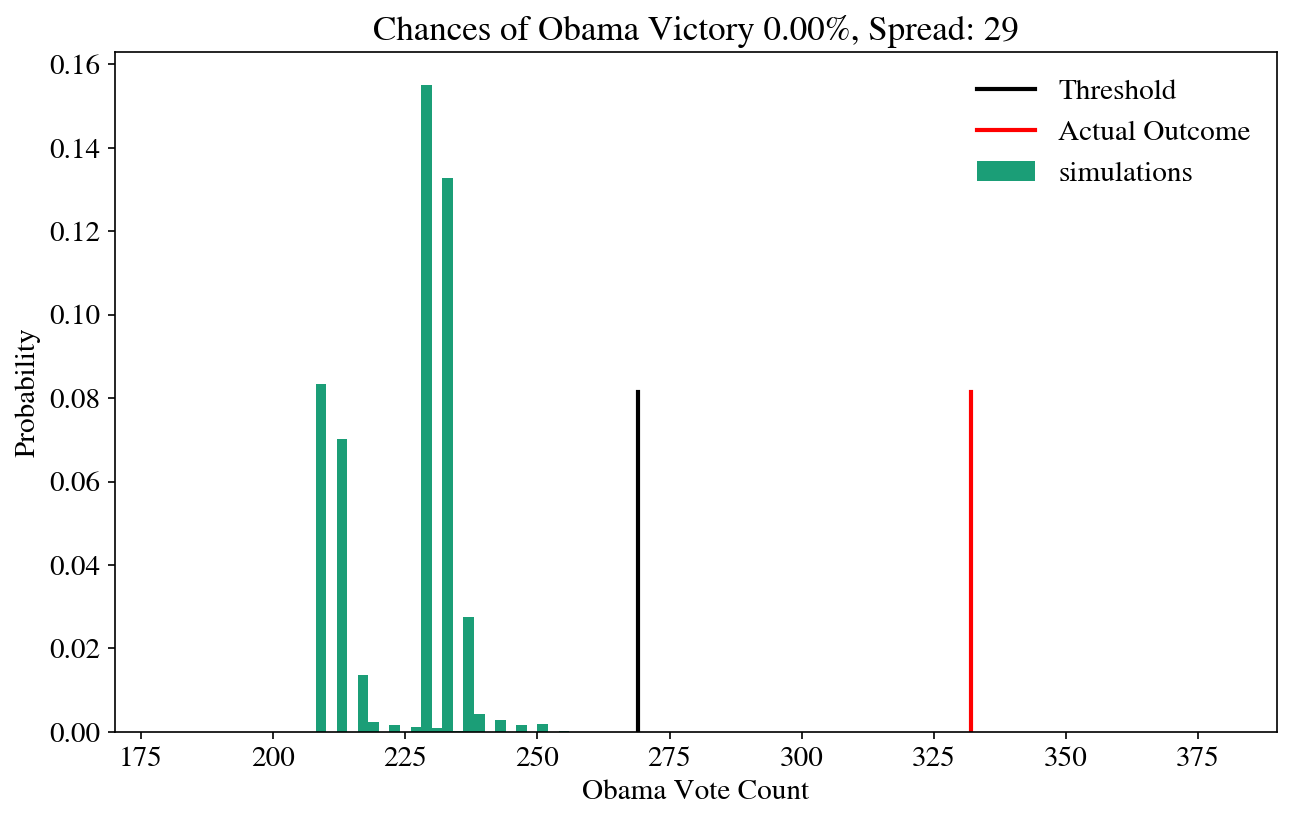

In [20]:
model = biased_gallup(gallup_2012, 1)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()

model = biased_gallup(gallup_2012, 5)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)
plt.show()

### Estimating the size of the bias from the 2008 election
While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct if we are able to estimate the size of the bias and adjust for it. This is one form of calibration.
One approach to calibrating a model is to use historical data to estimate the bias of a prediction model. We can use our same prediction model on historical data and compare our historical predictions to what actually occurred and see if, on average, the predictions missed the truth by a certain amount. Under some assumptions (discussed in a question below), we can use the estimate of the bias to adjust our current forecast.
In this case, we can use data from the 2008 election. (The Gallup data from 2008 are from the whole of 2008, including after the election):

In [21]:
gallup_08 = pd.read_csv("data/g08.csv").set_index('State')
results_08 = pd.read_csv('data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


[  1.26390486 -11.32855786]


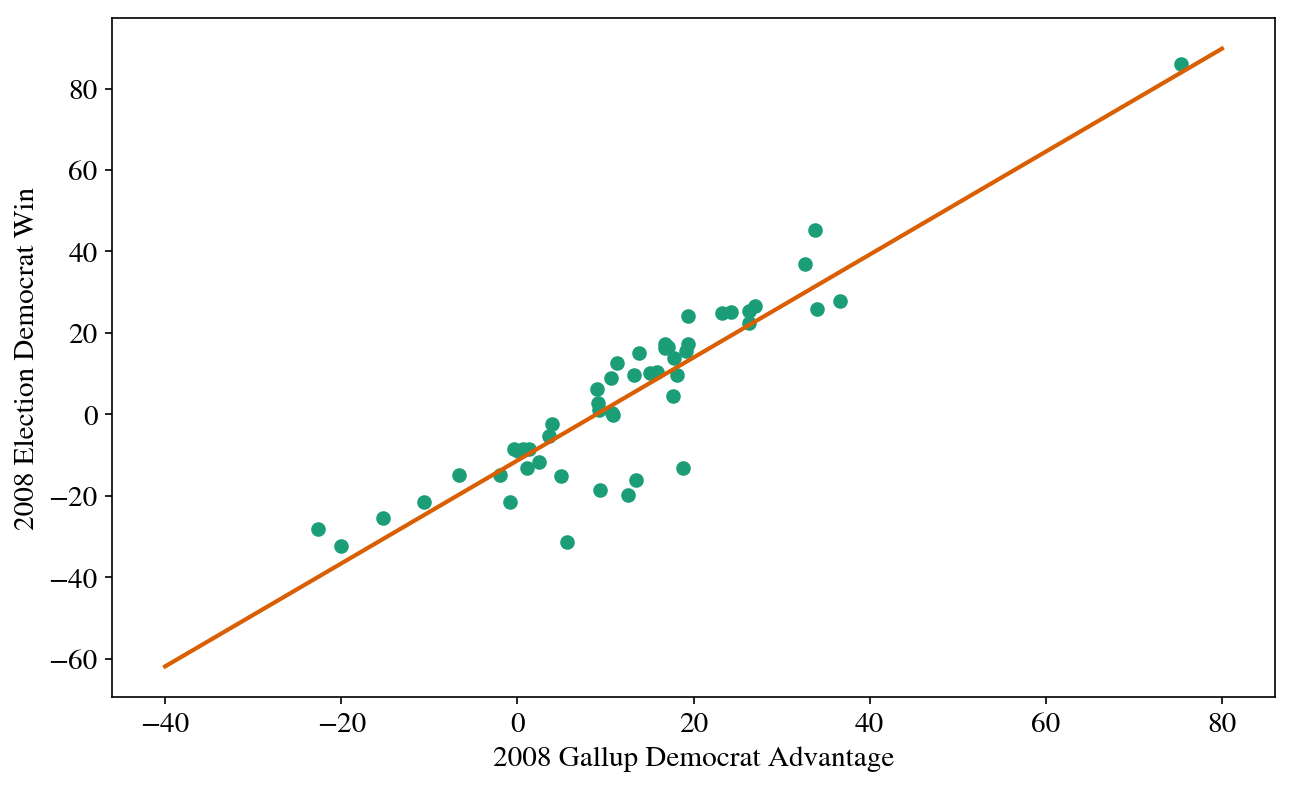

In [22]:

plt.plot(prediction_08.Dem_Adv, prediction_08.Dem_Win, 'o')
plt.xlabel("2008 Gallup Democrat Advantage")
plt.ylabel("2008 Election Democrat Win")
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, y)
print fit

Notice that a lot of states in which Gallup reported a Democratic affiliation, the results were strongly in the opposite direction.
A quick look at the graph will show you a number of states where Gallup showed a Democratic advantage, but where the elections were lost by the democrats.

In [23]:
prediction_08[(prediction_08.Dem_Win < 0) & (prediction_08.Dem_Adv > 0)]

,Dem_Adv,Dem_Win
State,,
Arkansas,12.5,-19.86
Georgia,3.6,-5.21
Kentucky,13.5,-16.23
Louisiana,9.4,-18.63
Mississippi,1.1,-13.18
Missouri,10.9,-0.14
Montana,3.9,-2.26
North Dakota,0.6,-8.63
Oklahoma,5.6,-31.30


We compute the average difference between the Democrat advantages in the election and Gallup poll

In [24]:
print (prediction_08.Dem_Adv - prediction_08.Dem_Win).mean()

8.06803921569


The bias was roughly 8% in favor of the Democrats in the Gallup Poll, meaning that you would want to adjust predictions based on this poll down by that amount. This was the result of people in a number of Southern and Western states claiming to be affiliated as Democrats, then voting the other way. Or, since Gallup kept polling even after the elections, it could also represent people swept away by the 2008 election euphoria in those states. This is an illustration of why one needs to be carefull with polls.


C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


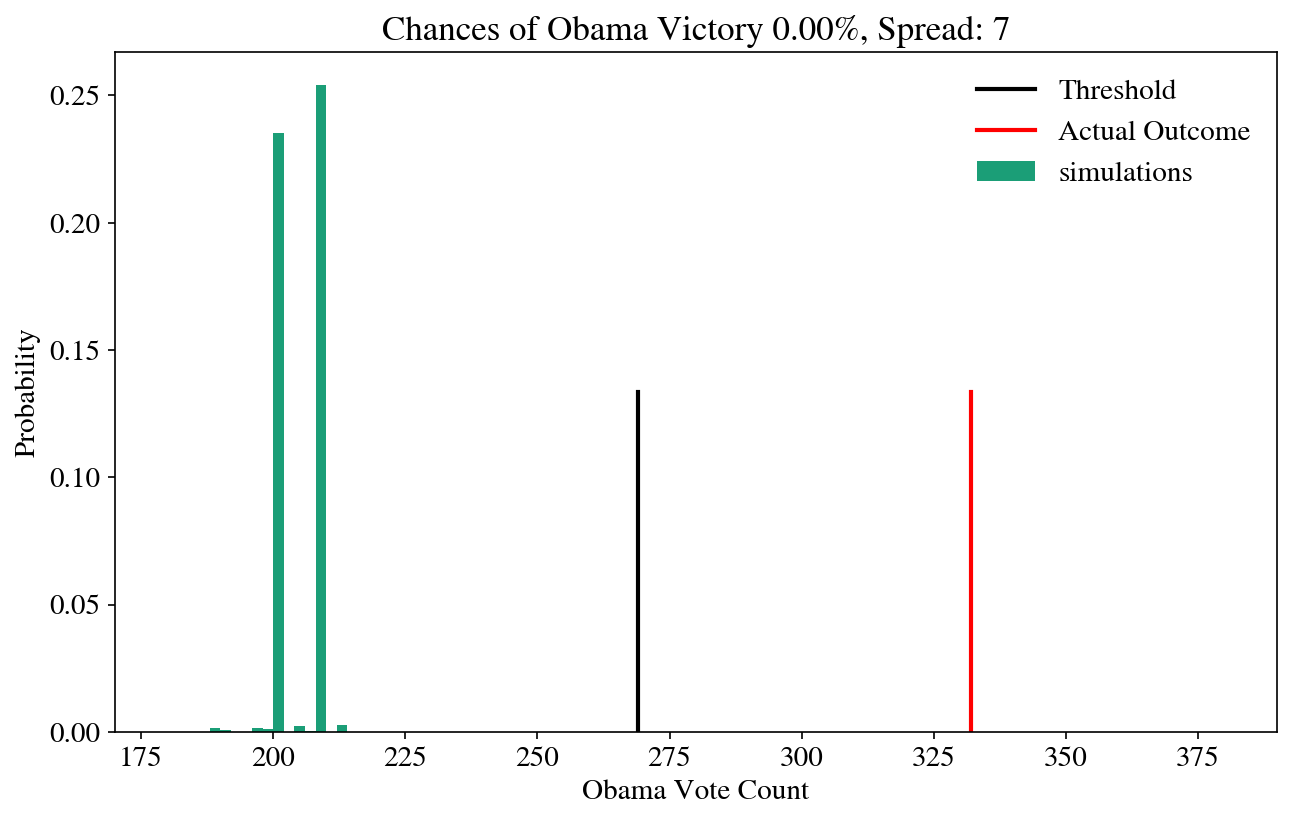

In [25]:
#Caliberating wrt to the bias from previos poll forecasts and results
model = biased_gallup(gallup_2012, 8.06)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

This was a disaster. The 8% calibration completey destroys the accuracy of our prediction in 2012. Our calibration made the assumptions that a) the bias in 2008 was the same as 2012, and b) the bias in each state was the same.


There are several ways in which these assumptions may have been violated. Gallup may have changed their methodology to account for this bias already, leading to a different bias in 2012 from what there was in 2008. The state-by-state biases may have also been different -- voters in highly conservative states may have responded to polls differently from voters in libreral states, for instance. It might have been better to callibrate the bias on a state-wide or clustered basis.

## Logistic Considerations

In the previous forecast, we used the strategy of taking some side-information about an election (the partisan affiliation poll) and relating that to the predicted outcome of the election. We tied these two quantities together using a very simplistic assumption, namely that the vote outcome is deterministically related to estimated partisan affiliation.

In this section, we use a more sophisticated approach to link side information -- usually called **features** or **predictors** -- to our prediction. This approach has several advantages, including the fact that we may use multiple features to perform our predictions. Such data may include demographic data, exit poll data, and data from previous elections.

First, we'll construct a new feature called PVI, and use it and the Gallup poll to build predictions. Then, we'll use **logistic regression** to estimate win probabilities, and use these probabilities to build a prediction.

#### The Partisan Voting Index

The Partisan Voting Index (PVI) is defined as the excessive swing towards a party in the previous election in a given state. In other words:

$$
PVI_{2008} (state) = 
Democratic.Percent_{2004} ( state ) - Republican.Percent_{2004} ( state) - \\ 
                \Big ( Democratic.Percent_{2004} (national) - Republican.Percent_{2004} (national) \Big )
$$

To calculate it, let us first load the national percent results for republicans and democrats in the last 3 elections and convert it to the usual `democratic - republican` format.

In [26]:
national_results=pd.read_csv("data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results.head()

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


Let us also load in data about the 2004 elections from `p04.csv` which gets the results in the above form for the 2004 election for each state.

In [27]:
polls04=pd.read_csv("data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [28]:
pvi08=polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

In [29]:
#Creating the dataframe to feed the model for training
e2008 = pd.DataFrame({'pvi':pvi08})
e2008['Dem_Adv']=prediction_08.Dem_Adv - prediction_08.Dem_Adv.mean()
e2008['obama_win']= (prediction_08.Dem_Win>0).astype(float)
e2008['Dem_Win'] = prediction_08.Dem_Win
e2008.head()

,pvi,Dem_Adv,obama_win,Dem_Win
State,,,,
Alabama,-23,-13.154902,0.0,-21.58
Alaska,-25,-22.954902,0.0,-21.53
Arizona,-8,-12.754902,0.0,-8.52
Arkansas,-6,0.145098,0.0,-19.86
California,12,7.045098,1.0,24.06


We construct a similar frame for 2012, obtaining `pvi` using the 2008 Obama win data which we already have. There is no `obama_win` column since, well, our job is to predict it!

In [30]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

,Dem_Adv,pvi
State,,
Alabama,-14.684314,-28.58
Alaska,-9.484314,-28.53
Arizona,-8.584314,-15.52
Arkansas,-0.384314,-26.86
California,12.615686,17.06


We load in the actual 2012 results so that we can compare our results to the predictions.

In [31]:
results2012 = pd.read_csv("data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


*Is the partisan vote index relatively stable from election to election?*

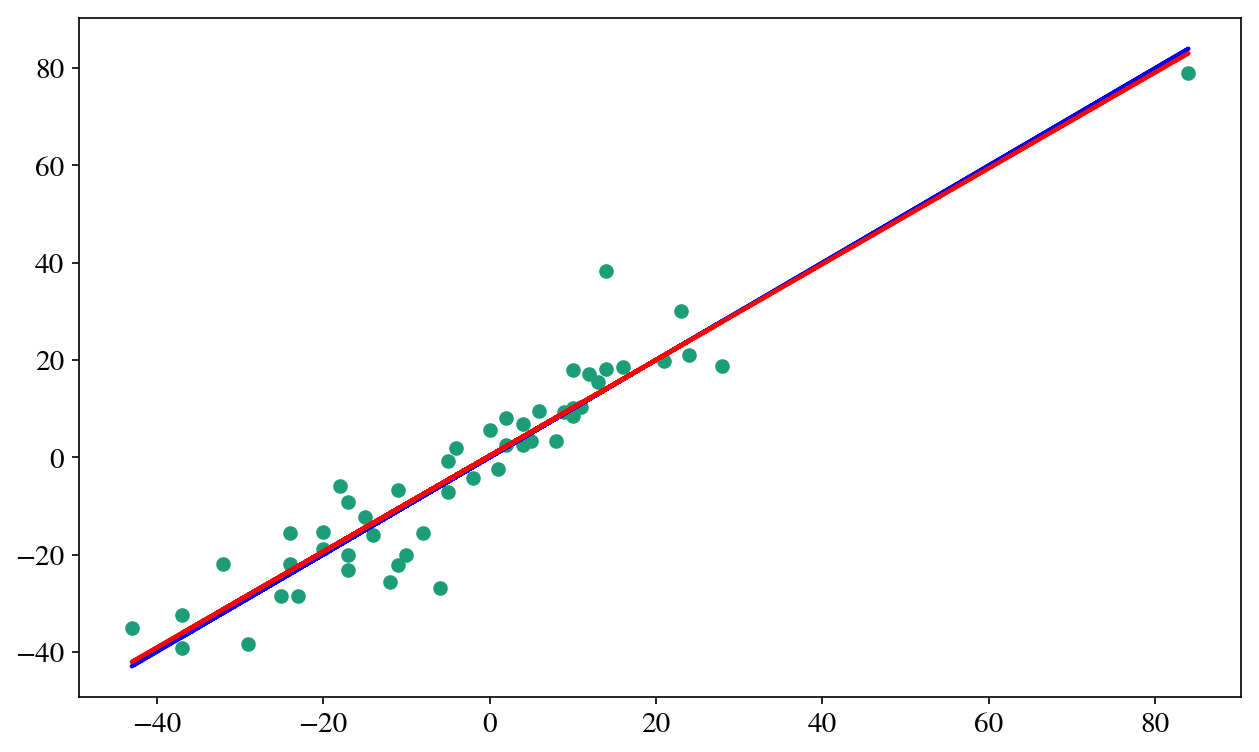

In [32]:
plt.scatter(e2008.pvi,e2012.pvi)
x = e2008.pvi
plt.plot(x,x,color='b')
fit = np.polyfit(e2008.pvi,e2012.pvi,1)
plt.plot(x,np.polyval(fit,x),color='r')

There is a reasonably well fit line which hugs the x=y line. This tells us that the PVI seems relatively stable from election to election and may thus make a good predictor.

*Let's see how the decision boundary is gonna look like when the the data is classified'*

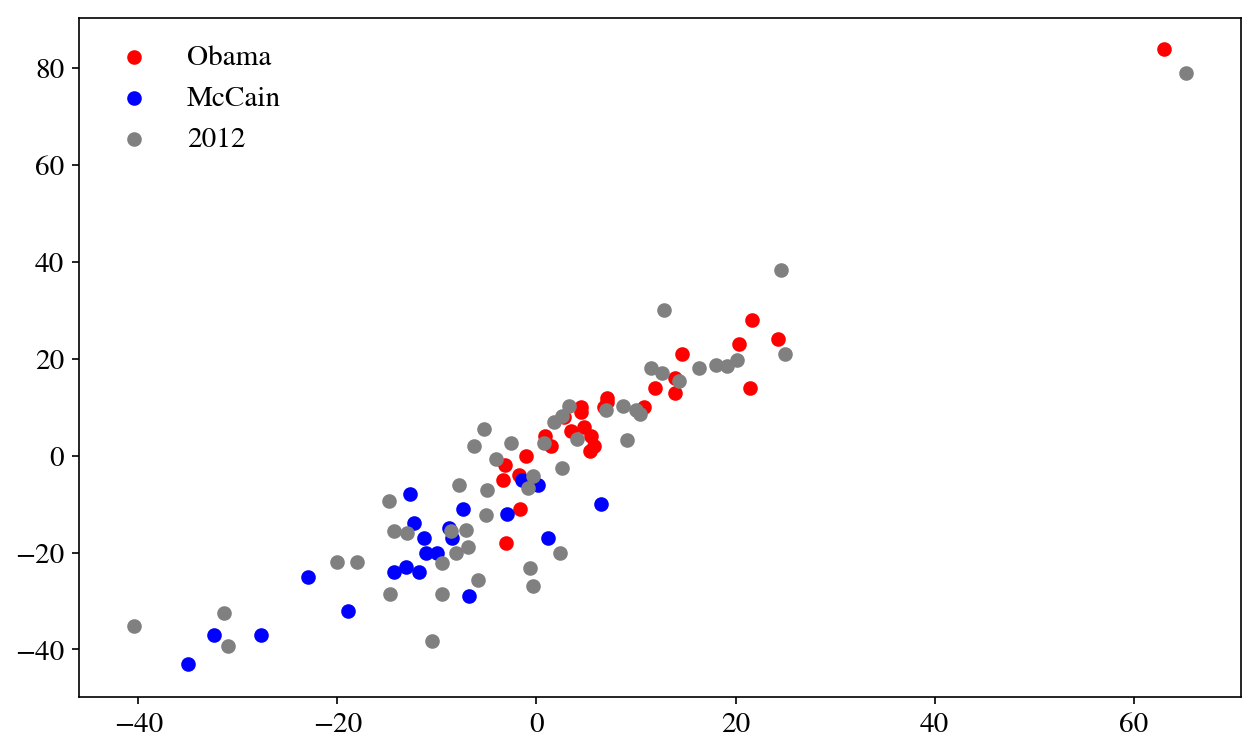

In [33]:
red_x = e2008[e2008.obama_win==1].Dem_Adv
red_y = e2008[e2008.obama_win==1].pvi
blue_x = e2008[e2008.obama_win==0].Dem_Adv
blue_y = e2008[e2008.obama_win==0].pvi
plt.scatter(red_x,red_y,color='r',label='Obama')
plt.scatter(blue_x,blue_y,color='b',label='McCain')
plt.scatter(e2012.Dem_Adv,e2012.pvi,color='grey',label = '2012')
plt.legend(frameon=False, scatterpoints=1, loc='upper left')

It seems that with 3-4 misclassifications, we could draw a line to divide the data into two parts.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

#prepare data for training
def prepare_features(frame2008, featureslist):
    y= frame2008.obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

#fitting the model on the data
def fit_logistic(frame2008, frame2012, featureslist, reg):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

#optimizing the hyperparameters to get the best generalizable output
def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

#Finally putting it all together
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

C:\Users\Samsung\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Samsung\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
modellr,clf = cv_and_fit(e2008,e2012,['Dem_Adv','pvi'])
modellr = modellr.join(electoral_votes)
modellr

,Obama,Votes
State,,
Alabama,0.004367,9
Alaska,0.008462,3
Arizona,0.068250,11
Arkansas,0.033851,6
California,0.994326,55
Colorado,0.601330,9
Connecticut,0.994041,7
Delaware,0.996920,3
District of Columbia,1.000000,3


C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


314.74950000000001

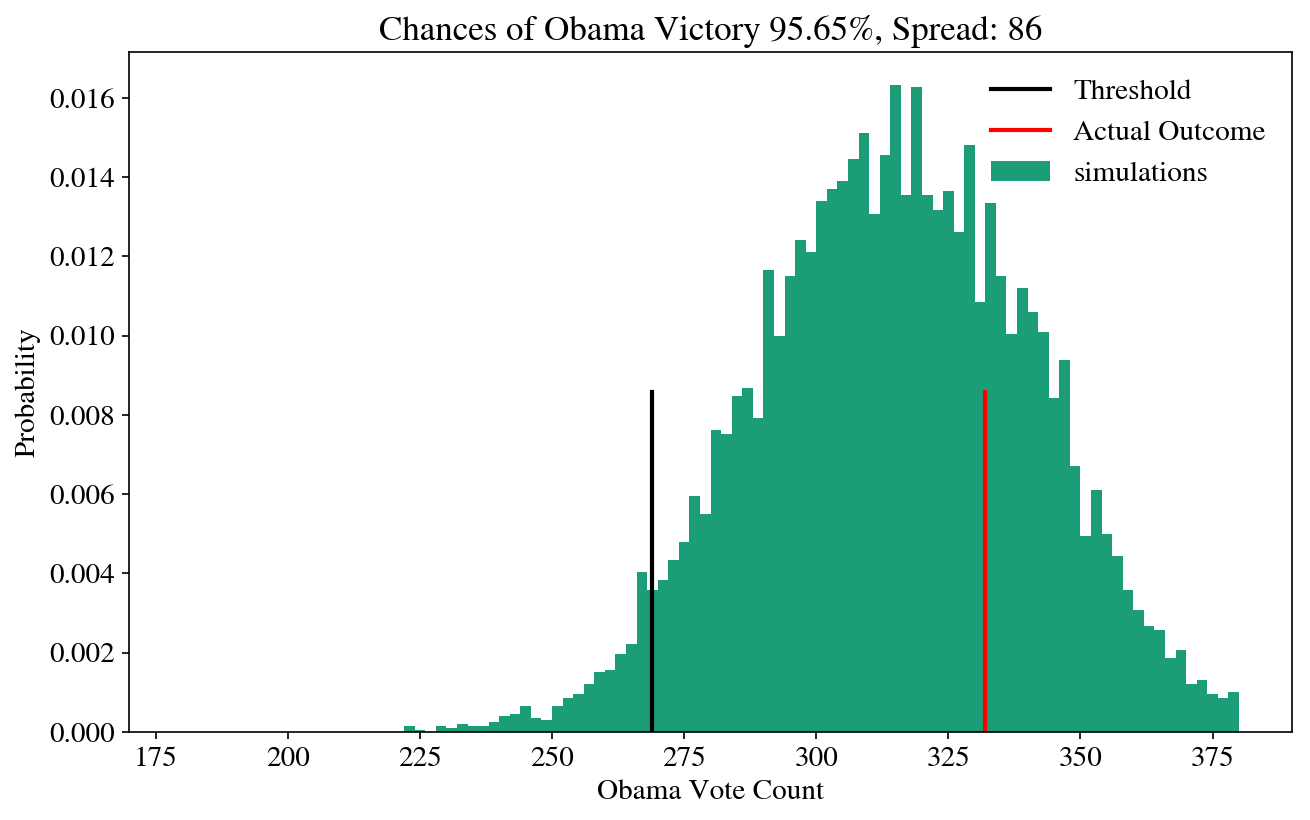

In [36]:
#simulate the prediction model and plot the simulation
pred_dist = simulate_election(modellr,10000)
plot_simulation(pred_dist)
pred_dist.mean()

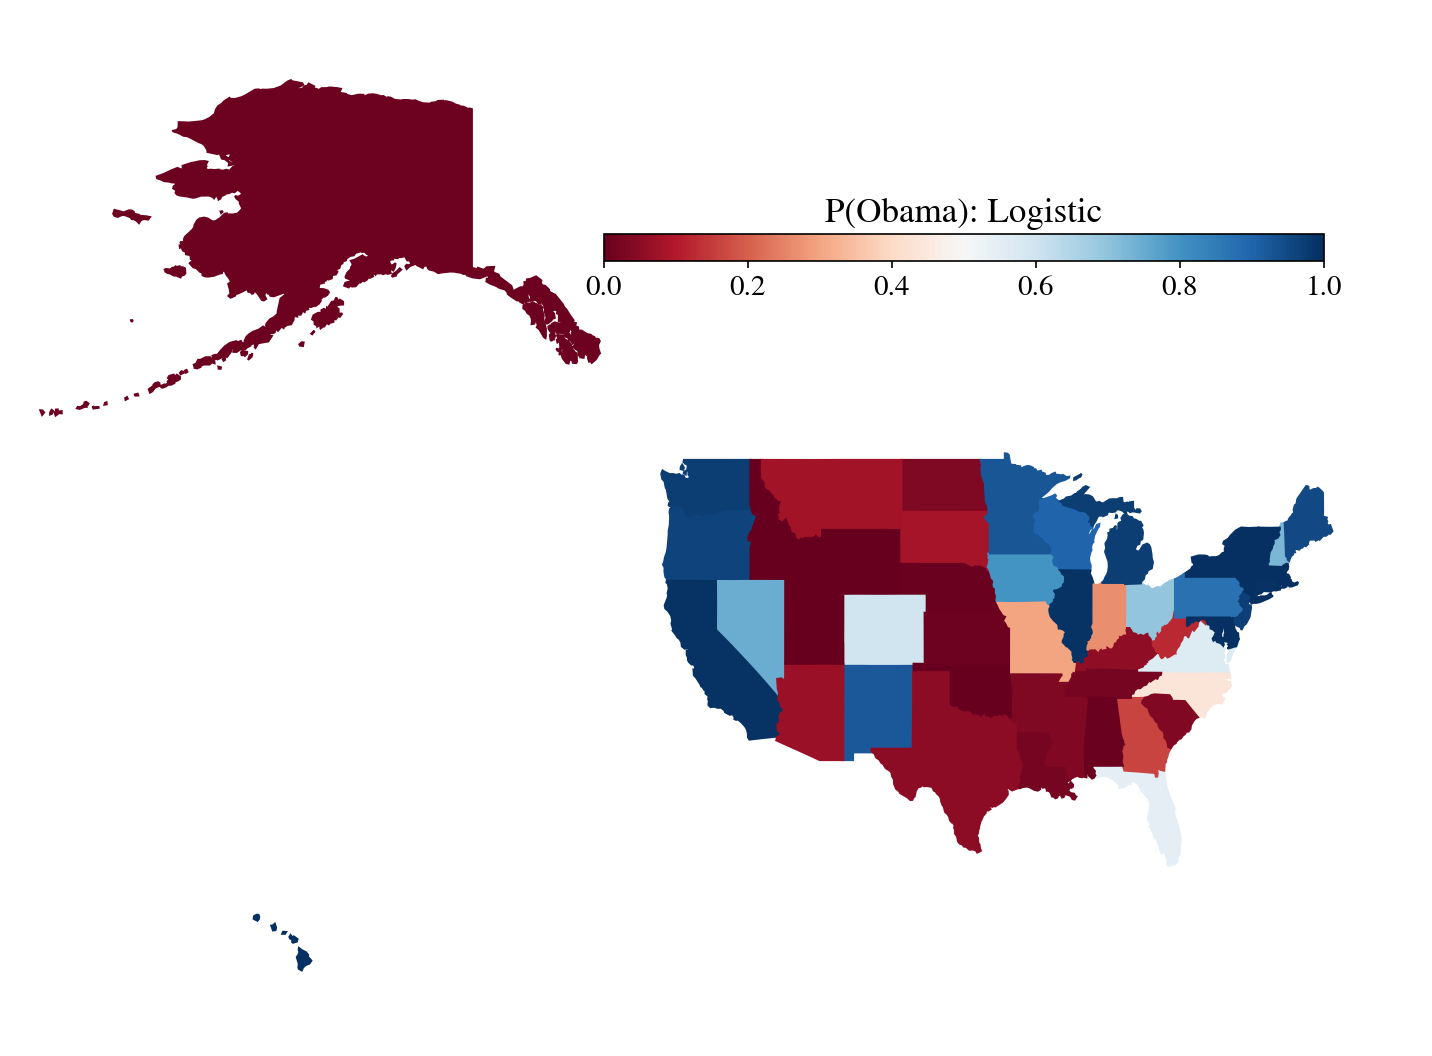

In [37]:
make_map(modellr.Obama, "P(Obama): Logistic")

The precision has worsened with respect to the predictwise (and even the gallup) model. The accuracy has improved with respect to the gallup model, but is not as good as in the predictwise model.


#### Classification decision boundary

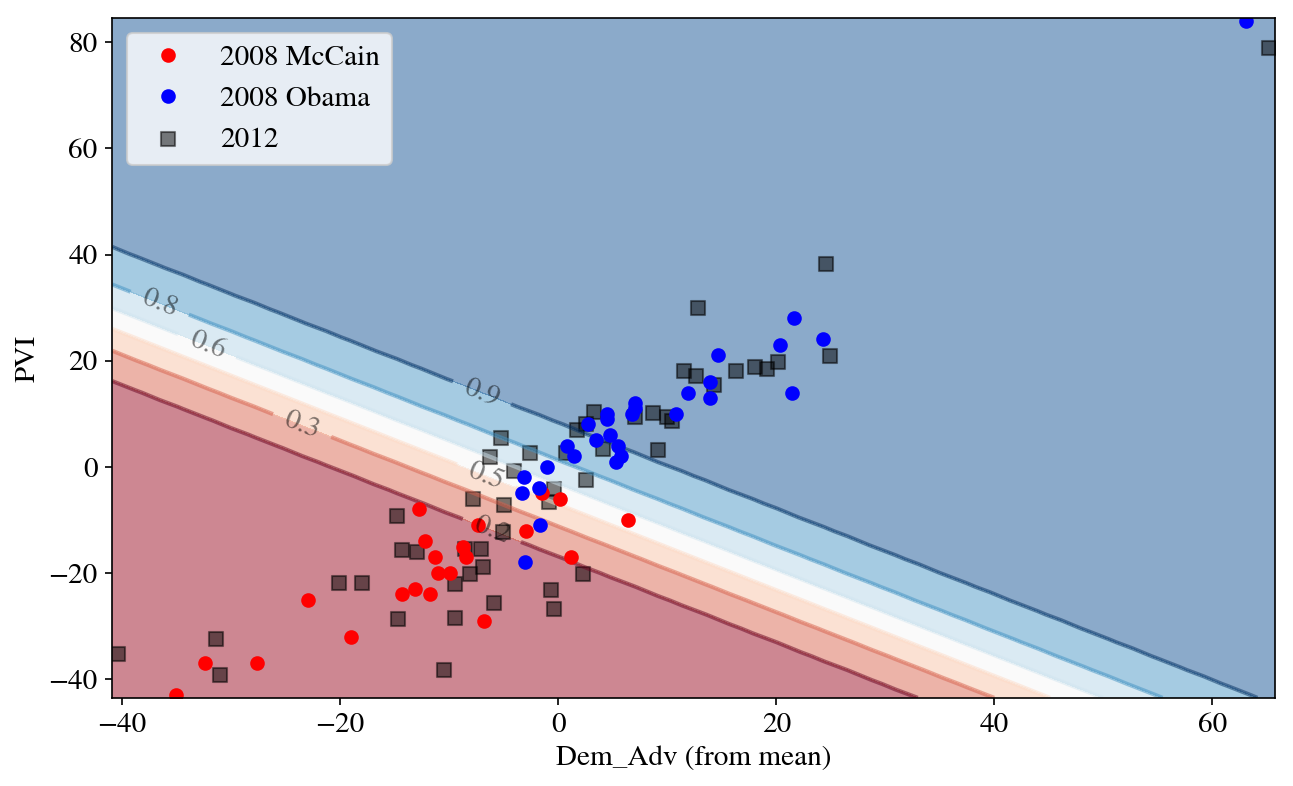

In [38]:
from matplotlib.colors import ListedColormap
def points_plot(e2008, e2012, clf):
    """
    e2008: The e2008 data
    e2012: The e2012 data
    clf: classifier
    """
    Xtrain = e2008[['Dem_Adv', 'pvi']].values
    Xtest = e2012[['Dem_Adv', 'pvi']].values
    ytrain = e2008['obama_win'].values == 1
    
    X=np.concatenate((Xtrain, Xtest))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    # Plot the 2008 points
    ax.plot(Xtrain[ytrain == 0, 0], Xtrain[ytrain == 0, 1], 'ro', label='2008 McCain')
    ax.plot(Xtrain[ytrain == 1, 0], Xtrain[ytrain == 1, 1], 'bo', label='2008 Obama')
        
    # and the 2012 points
    ax.scatter(Xtest[:, 0], Xtest[:, 1], c='k', marker="s", s=50, facecolors="k", alpha=.5, label='2012')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax
points_plot(e2008, e2012, clf)
plt.xlabel("Dem_Adv (from mean)")
plt.ylabel("PVI")

## Poll Aggregation

In the previous section, we tried to use heterogeneous side-information to build predictions of the election outcome. In this section, we switch gears to bringing together homogeneous information about the election, by aggregating different polling result together.

This approach -- used by the professional poll analysists -- involves combining many polls about the election itself. One advantage of this approach is that it addresses the problem of bias in individual polls, a problem we found difficult to deal with in problem 1. If we assume that the polls are all attempting to estimate the same quantity, any individual biases should cancel out when averaging many polls (pollsters also try to correct for known biases). This is often a better assumption than assuming constant bias between election cycles, as we did above.

The following table aggregates many of the pre-election polls available as of October 2, 2012. We are most interested in the column "obama_spread". We will clean the data for you:

In [39]:
multipoll = pd.read_csv('data/cleaned-state_data2012.csv', index_col=0)

#convert state abbreviation to full name
multipoll.State.replace(states_abbrev, inplace=True)

#convert dates from strings to date objects, and compute midpoint
multipoll.start_date = multipoll.start_date.apply(pd.to_datetime)
multipoll.end_date = multipoll.end_date.apply(pd.to_datetime)
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2

#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]

#drop unneeded columns
multipoll = multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1)

#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')

#drop rows with missing data
multipoll.dropna()

multipoll.head()

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52.0,41.0,500.0,11.0,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56.0,39.0,625.0,17.0,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53.0,36.0,405.0,17.0,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54.0,38.0,524.0,16.0,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54.0,37.0,524.0,17.0,2012-08-01 12:00:00,61.5,12


*Let's aggregate the polls*

In [40]:
"""
Function
--------
state_average

Inputs
------
multipoll : DataFrame
   The multipoll data above
   
Returns
-------
averages : DataFrame
  A dataframe, indexed by State, with the following columns:
     N: Number of polls averaged together
     poll_mean: The average value for obama_spread for all polls in this state
     poll_std: The standard deviation of obama_spread
     
Notes
-----
For states where poll_std isn't finite (because N is too small), estimate the
poll_std value as .05 * poll_mean
"""
def state_average(multipoll):
    df = pd.DataFrame(multipoll.groupby(['State'])['Pollster'].count())
    df['poll_mean'] = multipoll.groupby(['State'])['obama_spread'].mean().values
    df['poll_std'] = multipoll.groupby(['State'])['obama_spread'].std().values
    df.loc[df.poll_std.isnull(),'poll_std'] = 0.05 * df.loc[df.poll_std.isnull(),'poll_mean']
    return df

In [41]:
avg = state_average(multipoll).join(electoral_votes, how='outer')
avg.head()

,Pollster,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,NaN,NaN,9
Alaska,NaN,NaN,NaN,3
Arizona,20.0,-5.500000,4.559548,11
Arkansas,3.0,-20.333333,4.041452,6
California,20.0,18.950000,5.548589,55


Some of the reddest and bluest states are not present in this data (people don't bother polling there as much). The `default_missing` function gives them strong Democratic/Republican advantages

In [42]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.ix[red_states, ["poll_mean"]] = -100.0
    results.ix[red_states, ["poll_std"]] = 0.1
    results.ix[blue_states, ["poll_mean"]] = 100.0
    results.ix[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

,Pollster,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,-100.00,0.100000,9
Alaska,NaN,-100.00,0.100000,3
Arizona,20.0,-5.50,4.559548,11
Arkansas,3.0,-100.00,0.100000,6
California,20.0,18.95,5.548589,55


*Let's create the aggregated poll model*

In [43]:
"""
Function
--------
aggregated_poll_model

Inputs
------
polls : DataFrame
   DataFrame indexed by State, with the following columns:
      poll_mean
      poll_std
      Votes

Returns
-------
A DataFrame indexed by State, with the following columns:
   Votes: Electoral votes for that state
   Obama: Estimated probability that Obama wins the state
"""
from scipy.stats import norm
def aggregated_poll_model(df):
    fore = pd.DataFrame({"Votes":df.Votes},index = df.index)
    fore['Obama'] = norm.sf(0,df.poll_mean,df.poll_std)
    return fore
mod = aggregated_poll_model(avg)

C:\Users\Samsung\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1812: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Samsung\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Samsung\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Samsung\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1813: RuntimeWarning: invalid value encountered in greater
  cond1 = self._open_support_mask(x) & (scale > 0)
C:\Users\Samsung\Anaconda2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Samsung\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in less


314.3604


C:\Users\Samsung\Anaconda2\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


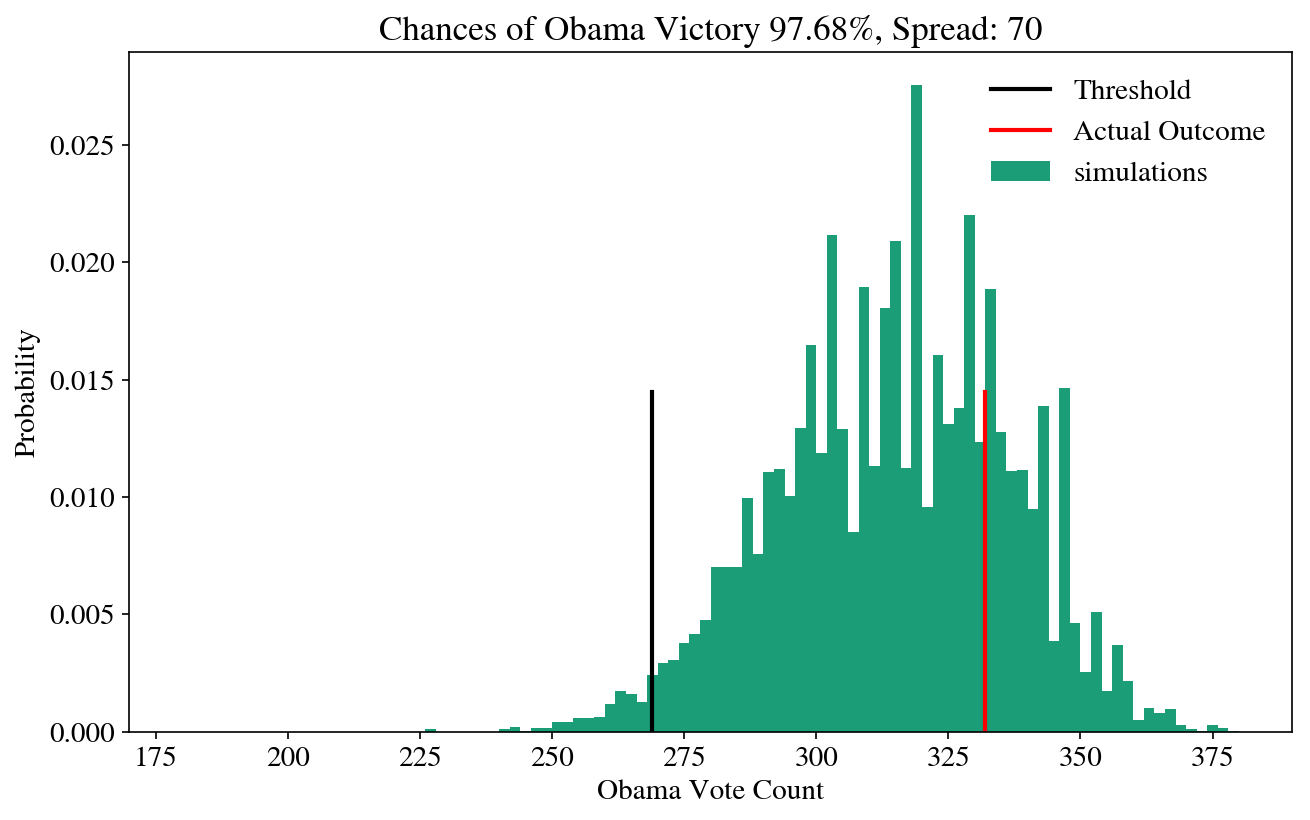

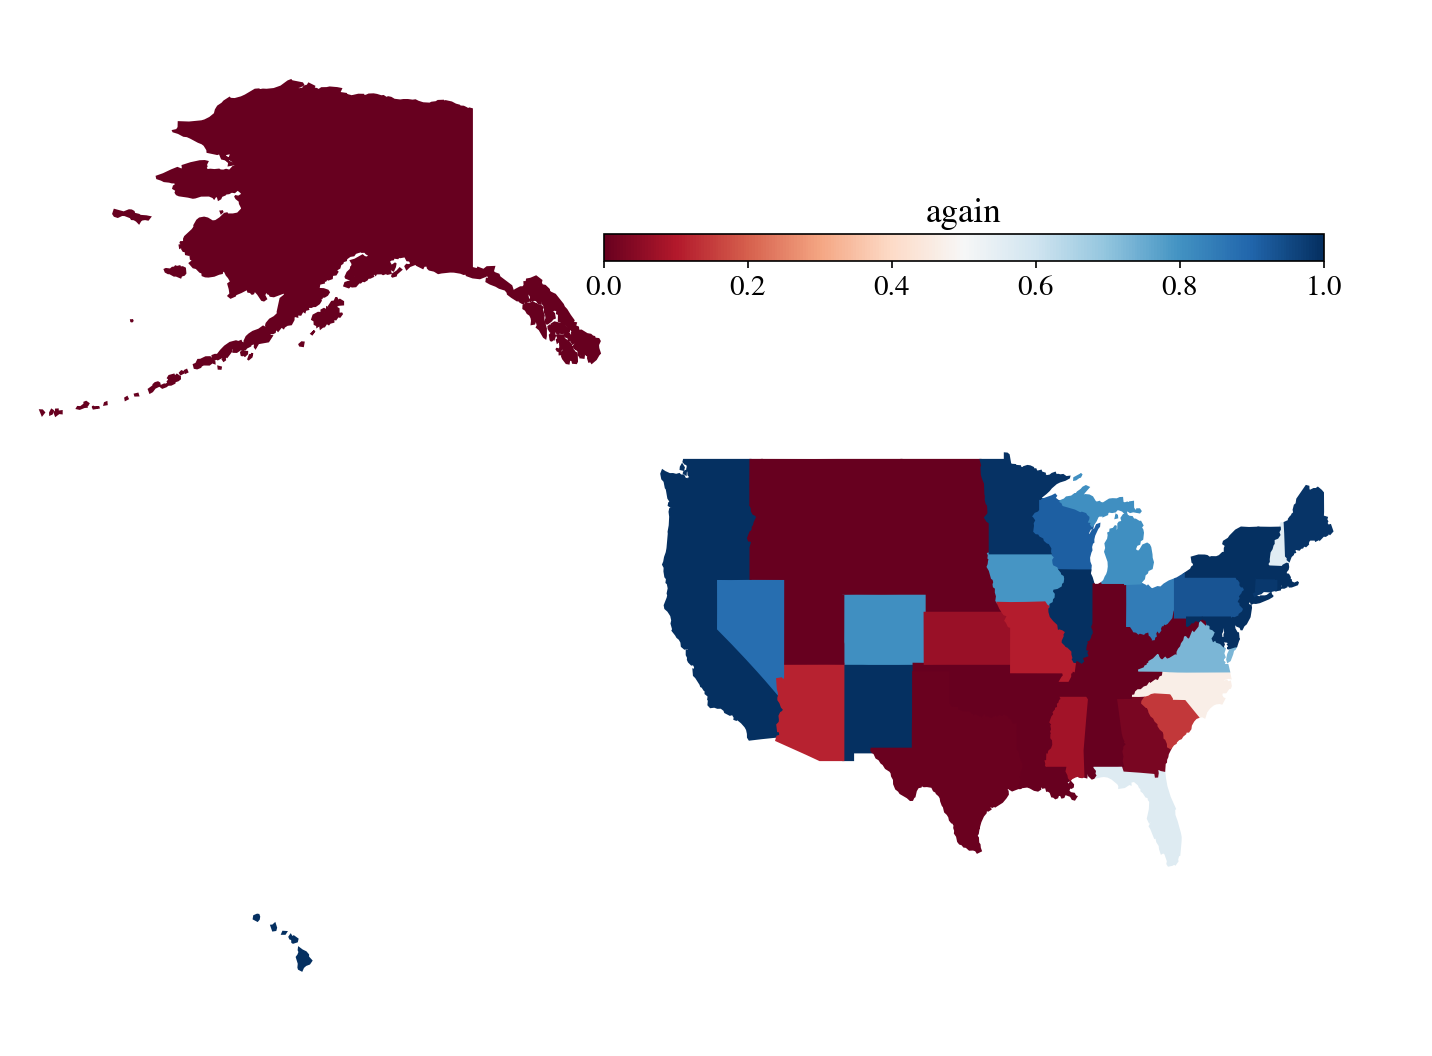

In [44]:
#simulating the model
sims = simulate_election(mod,10000)
print sims.mean()
plot_simulation(sims)
make_map(mod.Obama,'again')

The accuracy of this poll is somewhat greater than just taking the gallup poll. This is probably because


1.We're using as inputs polls that are trying to predict the election, so there is nothing "lost in translation", and
We are averaging many polls together, so some of their biases are likely to offset each other.


2.One problem is that we treated all polls as equal. Thus a bad poll with a small sample size is given equal footing as a good poll with a large one. Thus we are introducing bias both due to individual poll biases and individual poll sampling errors.


3.Furthermore, we estimate the standard deviation by simply taking the spread of the percentages in the polls, without considering their individual margins of error. In the limit of very limit sampling error per poll, this might be ok. However in states with some polls with large margins of error (Kansas, for eg), this can lead to an overestimate of the standard deviation, pushing the predicted probability toward 0.5. This, in turn, can hurt precision since it increases the chance that a state will flip sides in a simulation.

#### Parting Thoughts: What do the pros do?

The models we have explored have been fairly ad-hoc. Still, we have seen predicting by simulation, prediction using heterogeneous side-features, and finally by weighting polls that are made in the election season. The pros pretty much start from poll-averaging, adding in demographics and economic information, and moving onto trend-estimation as the election gets closer. They also employ models of likely voters vs registered voters, and how independents might break. At this point, you are prepared to go and read more about these techniques, so let us leave you with some links to read:

1. Skipper Seabold's reconstruction of parts of Nate Silver's model: https://github.com/jseabold/538model . We've drawn direct inspiration from his work , and indeed have used some of the data he provides in his repository

2. The simulation techniques are partially drawn from Sam Wang's work at http://election.princeton.edu . Be sure to check out the FAQ, Methods section, and matlab code on his site.

3. Nate Silver, who we are still desperately seeking, has written a lot about his techniques: http://www.fivethirtyeight.com/2008/03/frequently-asked-questions-last-revised.html . Start there and look around

4. Drew Linzer uses bayesian techniques, check out his work at: http://votamatic.org/evaluating-the-forecasting-model/